In [104]:
from fredapi import Fred
import pandas as pd

fred = Fred(api_key='b3b087757be00c02aa736d8c9ce707df')
real_gdp = fred.get_series('GDPC1')
potential_gdp = fred.get_series('GDPPOT')

data = pd.DataFrame({'real': real_gdp, 'potential': potential_gdp})
data.dropna(inplace=True)  # Remove rows w
data = data.resample('Q').mean()

data['gap'] = 100 * (data['real'] - data['potential']) / data['potential']

# Define frequency of data
data.tail()

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_48347/2148568881.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data = data.resample('Q').mean()


,real,potential,gap
2023-09-30,22780.933,22338.77,1.979352
2023-12-31,22960.600,22452.06,2.265004
2024-03-31,23053.545,22566.61,2.157768
2024-06-30,23223.906,22682.66,2.386166
2024-09-30,23386.248,22800.63,2.568429


In [105]:
from statsmodels.tsa.api import VAR

var_model = VAR(data.dropna())
var_results = var_model.fit(maxlags=3)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Nov, 2024
Time:                     16:35:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.3131
Nobs:                     300.000    HQIC:                   10.0909
Log likelihood:          -2738.45    FPE:                    20800.9
AIC:                      9.94268    Det(Omega_mle):         18852.2
--------------------------------------------------------------------
Results for equation real
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              -24.701639        22.180263           -1.114           0.265
L1.real              0.552500         0.107402            5.144           0.000
L1.potential        11.161223         3.457548            3.228  

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-package

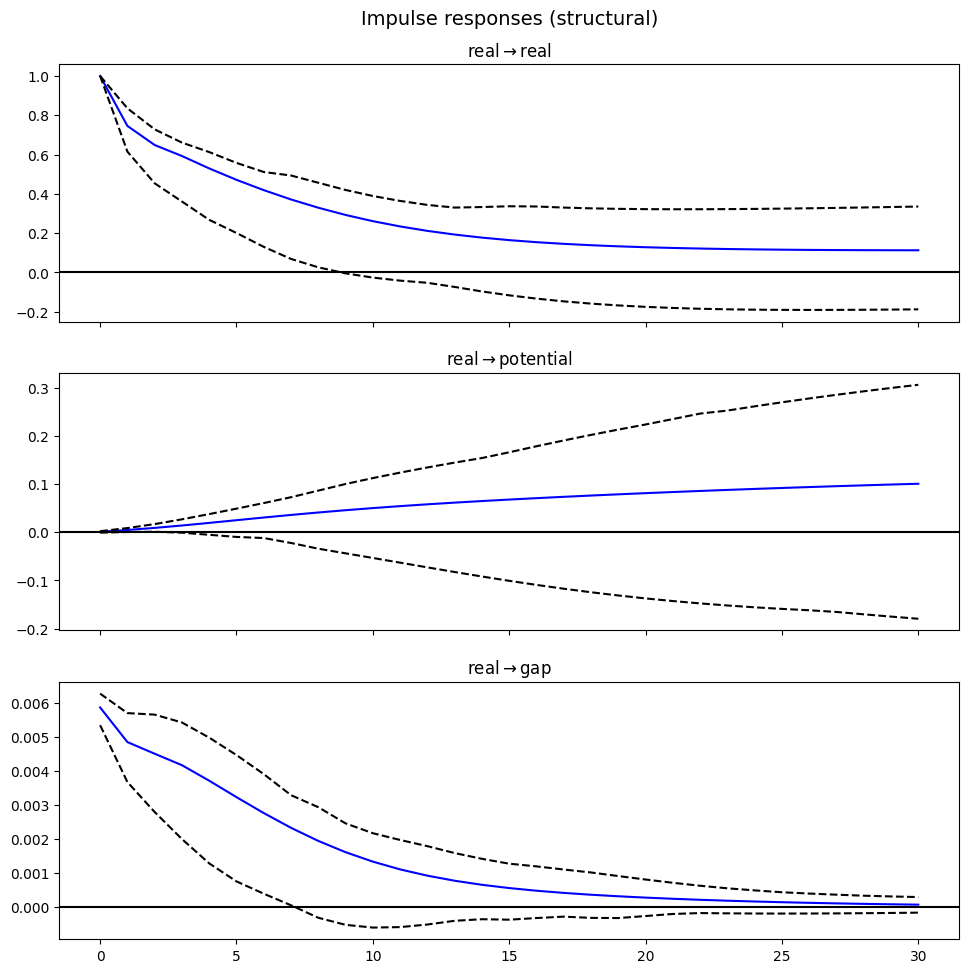

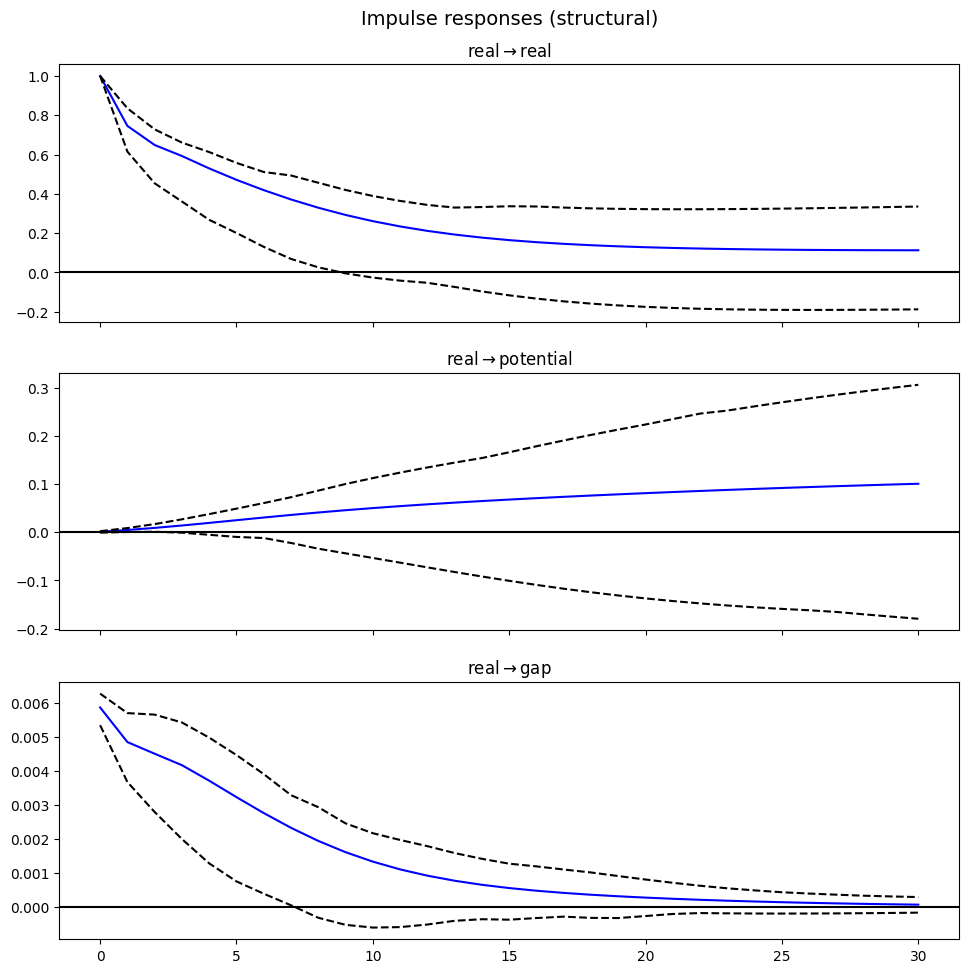

In [112]:
import numpy as np
from statsmodels.tsa.api import SVAR
# Specify structural matrices
A = np.array([[1, 0, 0],
              ["E", 1, 0],
              ["E", "E", 1]])  # Contemporaneous restrictions

B = np.array([[1, 0, 0],
              [0, 1, 0],
              ["E", 0, 1]])  # Long-run restrictions (identity in this case)

# Fit the SVAR model
svar_model = SVAR(data.dropna(), svar_type='AB', A=A, B=B)  # Use 'B' for long-run restrictions
svar_results = svar_model.fit(maxlags=3, maxiter=10000, maxfun=10000)

# Inspect results
svar_results.irf(periods=30).plot(impulse='real', plot_stderr=True,
                         stderr_type='mc', repl=100)

In [107]:
svar_results.k_exog_user = 0
svar_results.summary()

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Wed, 20, Nov, 2024
Time:                     16:35:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.3131
Nobs:                     300.000    HQIC:                   10.0909
Log likelihood:          -2738.45    FPE:                    20800.9
AIC:                      9.94268    Det(Omega_mle):         18852.2
--------------------------------------------------------------------
Results for equation real
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              -24.701639        22.180263           -1.114           0.265
L1.real              0.552500         0.107402            5.144           0.000
L1.potential        11.161223         3.457548            3.228  

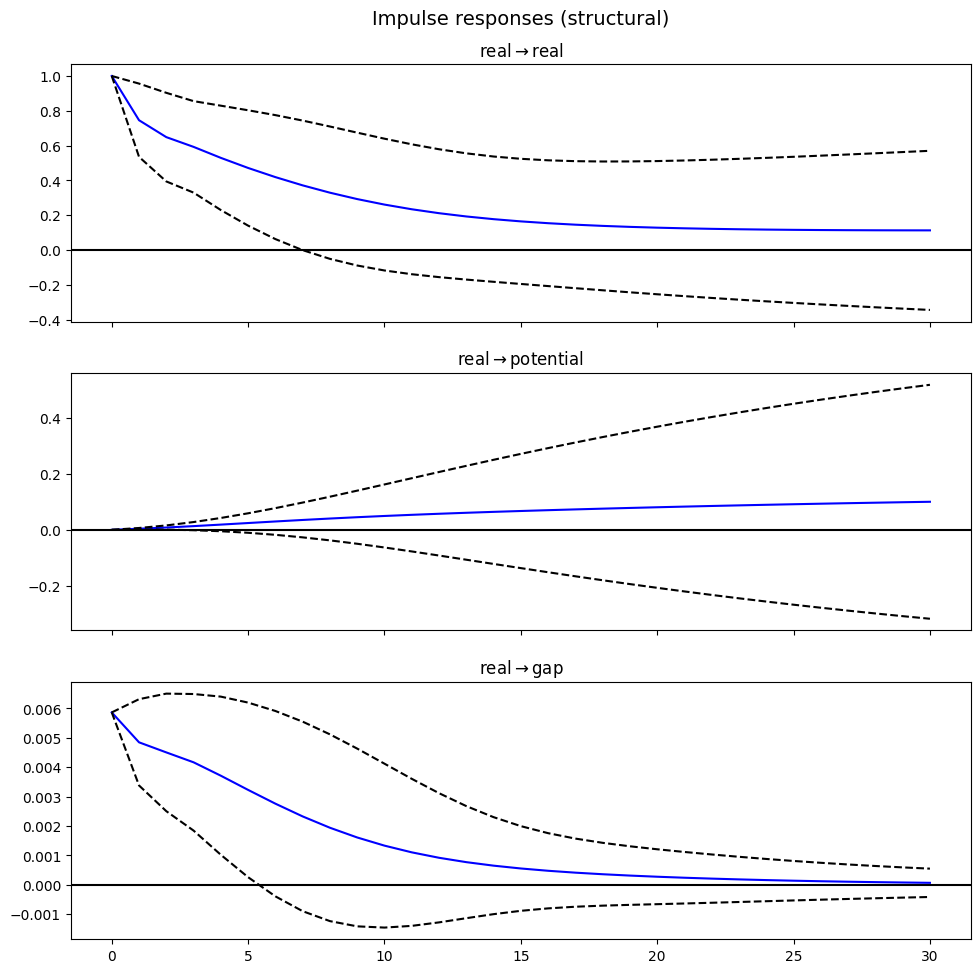

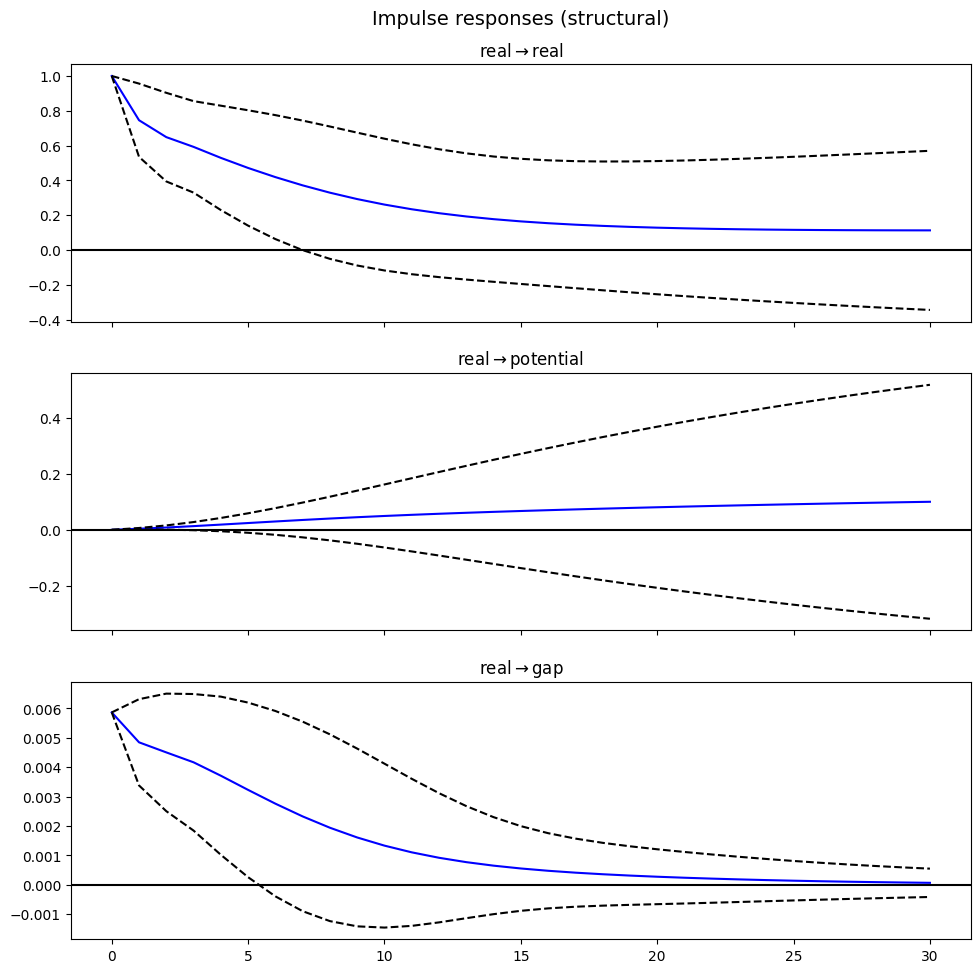

In [116]:
svar_results.irf(periods=30).plot(impulse='real', plot_stderr=True,stderr_type='asym', repl=100)